# Paillier Crypto

## Load Public Key

In [1]:
import os
from openfed.functional import PublicKey

if not os.path.isfile('/tmp/public.key'):
    raise FileNotFoundError(
        "Public Key is not found. Generate it using the `paillier_crypto_server` script."
    )
else:
    public_key = PublicKey.load('/tmp/public.key')
    print("Load public key from /tmp/public.key")
print(public_key)

ImportError: cannot import name 'samples_distribution' from 'openfed.data.utils' (/Users/densechen/miniconda3/envs/openfed/lib/python3.7/site-packages/openfed-0.0.0-py3.7.egg/openfed/data/utils/__init__.py)

## Download Dataset

In [1]:
from openfed.data import IIDPartitioner, PartitionerDataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

dataset = PartitionerDataset(
    MNIST(r'/tmp/', True, ToTensor(), download=True), total_parts=10, partitioner=IIDPartitioner())
import openfed
from openfed.data.utils import samples_distribution

digest(dataset, True)

ImportError: cannot import name 'samples_distribution' from 'openfed.data.utils' (/Users/densechen/miniconda3/envs/openfed/lib/python3.7/site-packages/openfed-0.0.0-py3.7.egg/openfed/data/utils/__init__.py)

## Dataloader

In [3]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0, drop_last=False)

## Network

In [4]:
import torch.nn as nn

network = nn.Linear(784, 10)
loss_fn = nn.CrossEntropyLoss()

## Optimizer

In [5]:
import torch
from openfed.federated import collaborator
from openfed.optim import FederatedOptimizer

optim = torch.optim.SGD(network.parameters(), lr=0.1)
fed_optim = FederatedOptimizer(optim, role=collaborator)

print(fed_optim)

<OpenFed> FederatedOptimizer
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)



## Topology

In [6]:
import openfed
from openfed.topo import Node, Topology, analysis

server_node = Node('server', openfed.default_tcp_address)
client = Node('client', openfed.empty_address)

topology = Topology()
topology.add_edge(client, server_node)

fed_props = analysis(topology, client)[0]

print(fed_props)

<OpenFed> FederatedProperties
+------------------+-----------+
|       role       | nick_name |
+------------------+-----------+
| openfed_collaborator |   client  |
+------------------+-----------+
<OpenFed> Address
+---------+---------------------+------------+------+
| backend |     init_method     | world_size | rank |
+---------+---------------------+------------+------+
|   gloo  | tcp://localhost:... |     2      |  1   |
+---------+---------------------+------------+------+




## Maintainer

In [7]:
from openfed.core import Maintainer

mt = Maintainer(fed_props, network.state_dict(keep_vars=True))

print(mt)

with mt:
    openfed.F.paillier(public_key)

<OpenFed> Maintainer
+------------------+-----------+-------+
|       role       | nick_name | pipes |
+------------------+-----------+-------+
| openfed_collaborator |   client  |   1   |
+------------------+-----------+-------+



## Step

In [8]:

import random
import time

version = 0
outter_losses = []
for outter in range(5):
    outter_loss = []
    for inner in range(2):
        mt.update_version(version)
        mt.step(upload=False)

        part_id = random.randint(0, 9)
        print(f"Select part_id={part_id}")
        dataset.set_part_id(part_id)

        network.train()
        losses = []
        tic = time.time()
        for data in dataloader:
            x, y = data
            output = network(x.view(-1, 784))
            loss = loss_fn(output, y)

            fed_optim.zero_grad()
            loss.backward()
            fed_optim.step()
            losses.append(loss.item())
        toc = time.time()
        loss = sum(losses) / len(losses)
        outter_loss.append(loss)
        duration = toc - tic

        fed_optim.round()

        mt.update_version(version + 1)
        mt.package(fed_optim)
        mt.step(download=False)
        fed_optim.clear_state_dict()

        print(
            f"Outter: {outter}, Inner: {inner}, version: {version}, loss: {loss:.2f}, duration: {duration:.2f}"
        )

    version += 1
    outter_losses.append(sum(outter_loss) / len(outter_loss))

Select part_id=9
Outter: 0, Inner: 0, version: 0, loss: 0.49, duration: 0.79
Select part_id=8
Outter: 0, Inner: 1, version: 0, loss: 0.41, duration: 0.75
Select part_id=4
Outter: 1, Inner: 0, version: 1, loss: 0.36, duration: 0.71
Select part_id=6
Outter: 1, Inner: 1, version: 1, loss: 0.36, duration: 0.79
Select part_id=9
Outter: 2, Inner: 0, version: 2, loss: 0.26, duration: 0.75
Select part_id=8
Outter: 2, Inner: 1, version: 2, loss: 0.34, duration: 0.66
Select part_id=7
Outter: 3, Inner: 0, version: 3, loss: 0.34, duration: 0.70
Select part_id=8
Outter: 3, Inner: 1, version: 3, loss: 0.31, duration: 0.78
Select part_id=4
Outter: 4, Inner: 0, version: 4, loss: 0.31, duration: 0.75
Select part_id=9
Outter: 4, Inner: 1, version: 4, loss: 0.24, duration: 0.71


## Loss

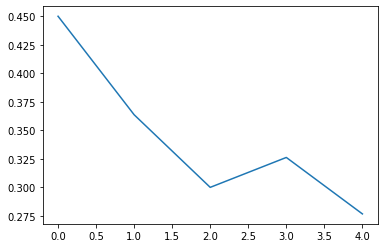

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()
plt.plot(outter_losses)
plt.show()